# Fit model of auxotrophic communities to data from range expansions experiments

We fit in total 4 parameters to the data, to estimate the leakage rate in the range expansion setup

- fit leakage rate of trp and pro are fitted to simultaneously to  community's A (dT+dP) equilibrium fraction and growth defect (expansion range dP+dT / expansion range in presence of AA). These were originally fitted to growth rates observed in microfluidic chambers but we expect effective leakage rates to be lower for colonies as the agar acts as a sink. 
- fit increase in pro uptake caused by putP over expression by fitting model to change in relative sector size (range dP / range dT) between community A (dT+dT) and B (dP-pEP17-putP + dT)
- fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)

Note: equation numbers refer to main text of van Vliet et al Plos Comp Bio 2022.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.ion()  # Turn on interactive mode

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))

## Load Data and set experimentally measured parameters

In [4]:
#init dictionary to store fit parameters
fit_pars = {} # parameters for the fit

#load dictionary width measured growth rates
with open('Experimental-datafiles/growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())
    
#we replace WT growth rate with average growth rate of dP and dT in presence of AA, as this is our actual control condition
growth_rates['WT'] = (growth_rates['dP'] + growth_rates['dT'])/2    

#load range expansion data
df = pd.read_csv('Experimental-datafiles/community_data.csv')

#add relative patch width
df['rel_range'] = df['dP_patch']/df['dT_patch']
df.head(n=18)

,Strain,Condition,Rep,dP_patch,dT_patch,Ratio,Width,rel_range
0,Ctr,A,1,53.487184,NaN,0.236473,120.791470,NaN
1,Pu,B,1,7.582256,9.833300,0.415781,134.280570,0.771080
2,Tp,C,1,14.930102,11.936463,0.557107,12.535128,1.250798
3,Pu Tp,D,1,NaN,13.316837,0.577874,260.262070,NaN
4,Pp,E,1,NaN,118.813790,0.109514,859.983100,NaN
5,Pp Pu,F,1,173.521930,123.065970,0.286427,852.356810,1.409991
6,Pp Tp,G,1,107.501130,96.755014,0.352019,957.622090,1.111065
7,Pu Pp Tp,H,1,137.002870,115.181930,0.326971,870.747640,1.189448
8,Ctr + aa,AA,1,134.417290,156.277080,0.452029,1269.088200,0.860122
9,Ctr,A,2,48.315732,9.073012,0.261400,157.898040,5.325214


In [5]:
#average over biological replicates
df_mean = df.groupby('Condition')[['Ratio', 'Width', 'dT_patch', 'dP_patch', 'rel_range']].mean()
df_mean['Ratio_std'] = df.groupby('Condition')['Ratio'].std()
df_mean['rel_range_std'] = df.groupby('Condition')['rel_range'].std()
df_mean['N_range'] = df.groupby('Condition')['rel_range'].count()
df_mean['N_eq'] = df.groupby('Condition')['Ratio'].count()
df_mean.reset_index(inplace=True)
df_mean['rel_growth'] = df_mean['Width'] / df_mean.loc[df_mean['Condition'] == 'AA', 'Width'].values[0]
df_mean.head(n=9)

,Condition,Ratio,Width,dT_patch,dP_patch,rel_range,Ratio_std,rel_range_std,N_range,N_eq,rel_growth
0,A,0.240606,99.855964,11.290686,52.947683,4.851652,0.016386,1.751668,5,6,0.083977
1,AA,0.458083,1189.085333,150.578212,148.406206,0.987414,0.028464,0.125339,5,6,1.000000
2,B,0.389557,165.937761,9.237860,10.536059,1.197904,0.028002,0.727514,4,6,0.139551
3,C,0.557368,-0.490553,8.585891,18.913275,2.146284,0.022064,1.714038,5,6,-0.000413
4,D,0.572360,298.223023,22.793291,5.035559,0.214834,0.005222,0.081480,4,5,0.250800
5,E,0.161826,803.814898,117.138821,227.426170,2.029934,0.048937,0.500054,5,6,0.675994
6,F,0.300507,854.308373,120.195380,176.149557,1.286966,0.038927,0.228003,5,6,0.718458
7,G,0.334571,846.470842,105.564071,116.726639,1.123821,0.075601,0.036914,5,6,0.711867
8,H,0.308416,873.030568,112.732017,136.856448,1.197953,0.057034,0.107858,4,6,0.734203


## Define functions

In [6]:
def report_data(df, condition):
    '''Report data for a given condition'''
    df_sum = df[df['Condition']==condition]    
    print(f"Experiments: C{condition:s}: f(dT) = {df_sum['Ratio'].mean():.2f}, rel. growth = {df_sum['rel_growth'].mean():.2f}, sectors dP = {df_sum['dP_patch'].mean():.2f}um, sectors dT = {df_sum['dT_patch'].mean():.2f}um, sector ratio = {df_sum['rel_range'].mean():.2f}")
    return None

def fit_1D(x, y_data, y_model):
    ''' Fit 1D data'''
    L2_norm = (y_model - y_data)**2
    min_idx = np.argmin(L2_norm)
    
    fitted_x = x[min_idx]    
    fig, axs = plt.subplots(1,1,figsize=(5,3))
    
    axs.plot(x, y_model, label='model')
    axs.plot(x, np.ones_like(x) * y_data.mean(), label='data')
    axs.axvline(x=fitted_x, color='k', linestyle='--')
    
    if min_idx == x.size-1:
        fitted_x = np.nan
    
    return (fitted_x, min_idx)     

def fit_2D(x, y, z1, z2, z1_data, z2_data, log_scale=False):
    ''' Fit 2D data'''  
    delta1 = (z1 - z1_data)/z1_data
    delta2 = (z2 - z2_data)/z2_data
    L2_norm_comb = np.log10(delta1**2 + delta2**2)

    idx_y, idx_x = np.unravel_index(np.argmin(L2_norm_comb), L2_norm_comb.shape)
    xfit = x[idx_x]
    yfit = y[idx_y]

    fig,axs = plt.subplots(1,3,figsize=(15,5))

    im0 = axs[0].imshow(z1, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im0, ax=axs[0])
    axs[0].contour(x, y, z1, levels=[z1_data.mean()], colors='r')
    axs[0].contour(x, y, z2, levels=[z2_data.mean()], colors='m')
    axs[0].axvline(x=xfit, color='k', linestyle='--')
    axs[0].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')

    im1 = axs[1].imshow(z2, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower',aspect='auto')
    fig.colorbar(im1, ax=axs[1])
    axs[1].contour(x, y, z1, levels=[z1_data.mean()], colors='m')
    axs[1].contour(x, y, z2, levels=[z2_data.mean()], colors='r')
    axs[1].axvline(x=xfit, color='k', linestyle='--')
    axs[1].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

    im2 = axs[2].imshow(L2_norm_comb, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
    fig.colorbar(im2, ax=axs[2])
    axs[2].axvline(x=xfit, color='k', linestyle='--')
    axs[2].axhline(y=yfit, color='k', linestyle='--')
    
    #set axis to log scale
    if log_scale:
        axs[2].set_xscale('log')
        axs[2].set_yscale('log')

    return (xfit, yfit)

---
## Fit leakage rates to community A

We fit leakage rate of trp and pro are fitted to simultaneously to  community's A (dT+dP) equilibrium fraction and growth defect (expansion range dP+dT / expansion range in presence of AA). These were originally fitted to growth rates observed in microfluidic chambers but we expect effective leakage rates to be lower for colonies as the agar acts as a sink. 


Pro leakage = 6.42e-07 (original = 1.59e-05), Trp leakage = 4.71e-08 (original = 6.04e-07)

Model predictions for community A, fit leakage:
Frequency dT = 0.24
Clustering dT = 0.99, Clustering dP = 1.00
Growth relative to WT = 0.08
Growth defect spatial community = 0.99
mu_max dP = 0.08, mu_max dT = 0.03
range dP = 11.86um, range dT = 2.80um, range dP/dT = 4.23

Experimental measurements of community A:
Experiments: CA: f(dT) = 0.24, rel. growth = 0.08, sectors dP = 52.95um, sectors dT = 11.29um, sector ratio = 4.85


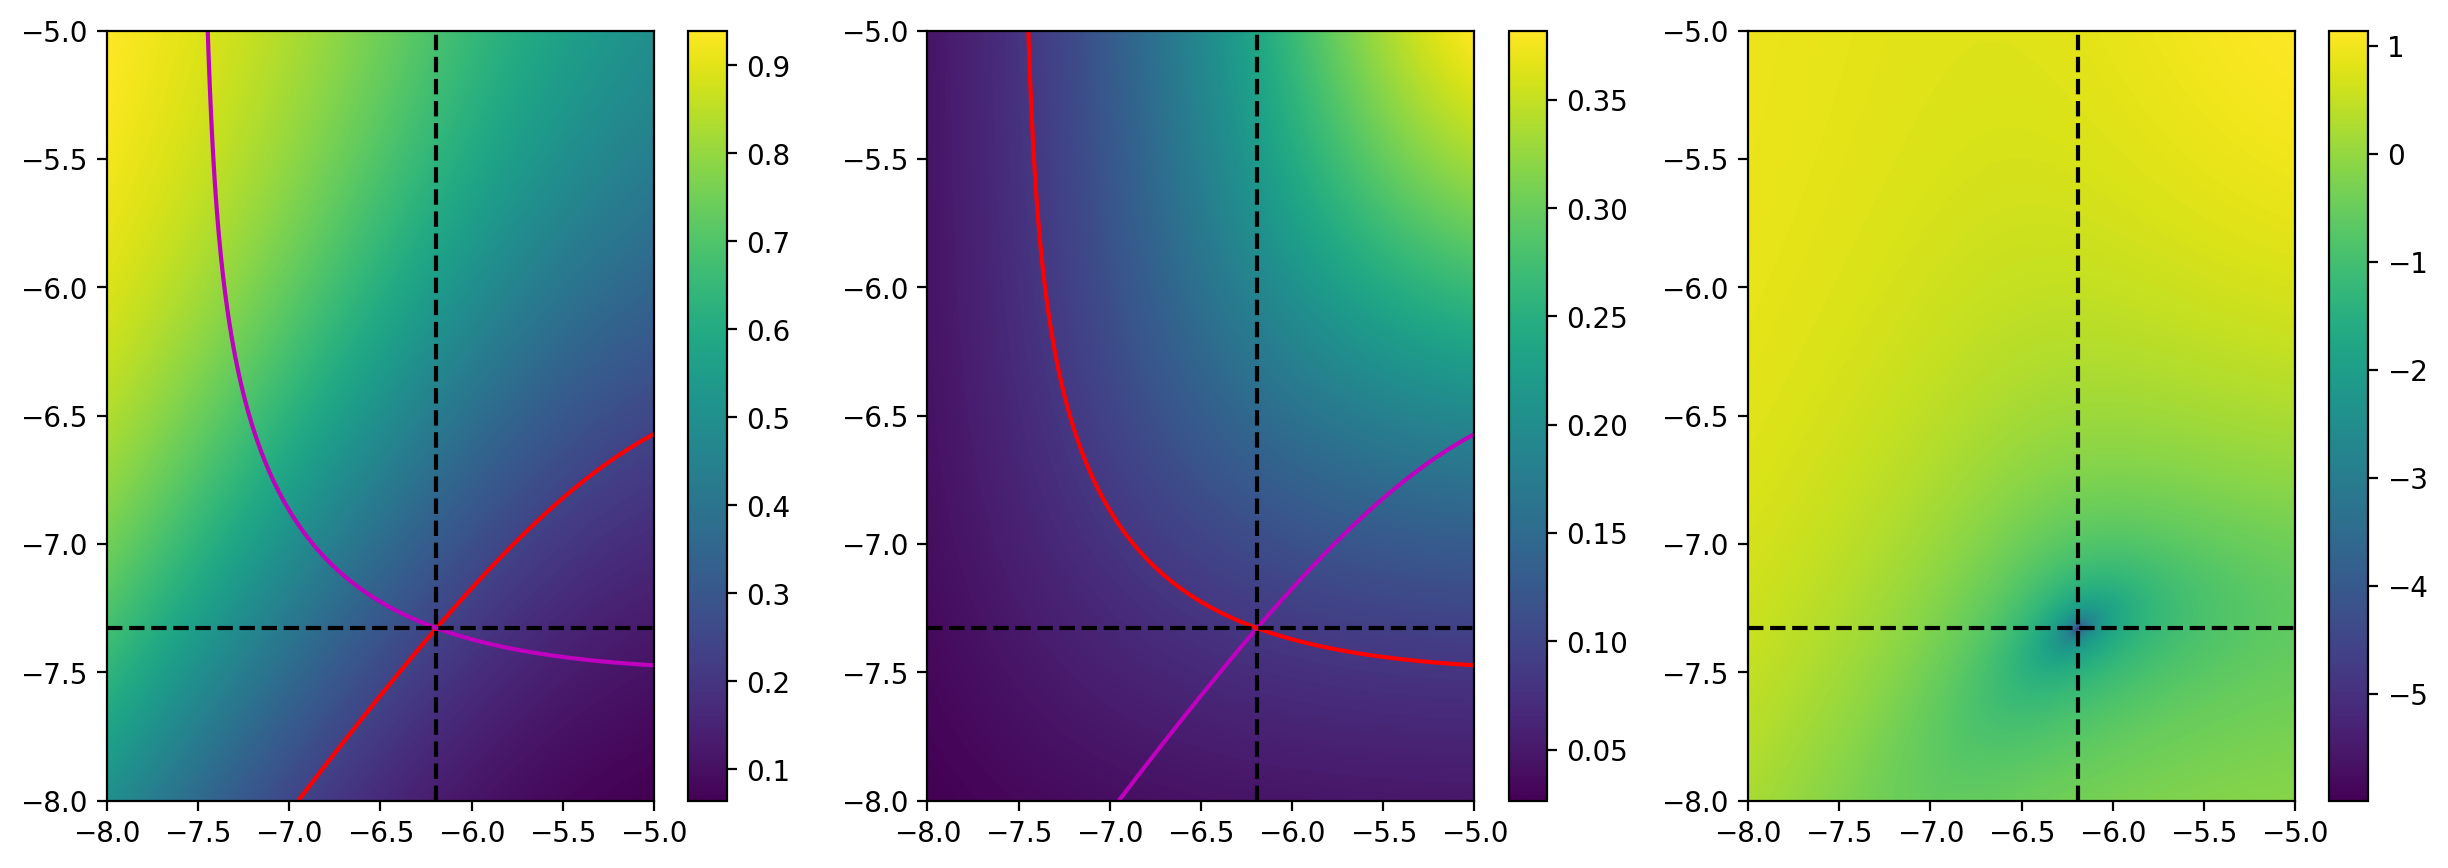

In [11]:

def_com = community(ndim=3) #baseline community

#perform 2d data fit, fit on log-transformed leakage rates
lPro = np.linspace(-8,-5,1000)
lTrp = np.linspace(-8,-5,1000)
xmat, ymat = np.meshgrid(lPro, lTrp)

#fit leakage parameters to equilibrium and relative growth data
eq_data = df_mean.loc[df_mean['Condition']=='A']['Ratio'].values[0] 
growth_data = df_mean.loc[df_mean['Condition']=='A']['Width'].values[0] / df_mean.loc[df_mean['Condition']=='AA']['Width'].values[0] 

#fit community
community_A0 = community(ndim=3, 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP'],
                         lPro=10**xmat, lTrp=10**ymat)

xfit, yfit = fit_2D(lPro, lTrp, community_A0.eq, community_A0.rel_growth_wt, eq_data, growth_data)
lPro_fit = 10**xfit
lTrp_fit = 10**yfit

fit_pars['lPro'] = lPro_fit
fit_pars['lTrp'] = lTrp_fit

#report fit parameters
print(f"Pro leakage = {lPro_fit:.3g} (original = {def_com.lPro:.3g}), Trp leakage = {lTrp_fit:.3g} (original = {def_com.lTrp:.3g})")

community_A0_fit = community(ndim=3,  
                             mu_WT=growth_rates['WT'], 
                             mu_dT=growth_rates['dT'], 
                             mu_dP=growth_rates['dP'],
                             lPro=fit_pars['lPro'], 
                             lTrp=fit_pars['lTrp'])

print('\nModel predictions for community A, fit leakage:')
community_A0_fit.report_properties()

print('\nExperimental measurements of community A:')
report_data(df_mean, 'A')
plt.show()

----

## Characterize trpR using community C

We fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)

c_prod_T_P = 33.90, eqFrac = 0.56, relmu = 0.22
Experiments: CC: f(dT) = 0.56, rel. growth = -0.00, sectors dP = 18.91um, sectors dT = 8.59um, sector ratio = 2.15


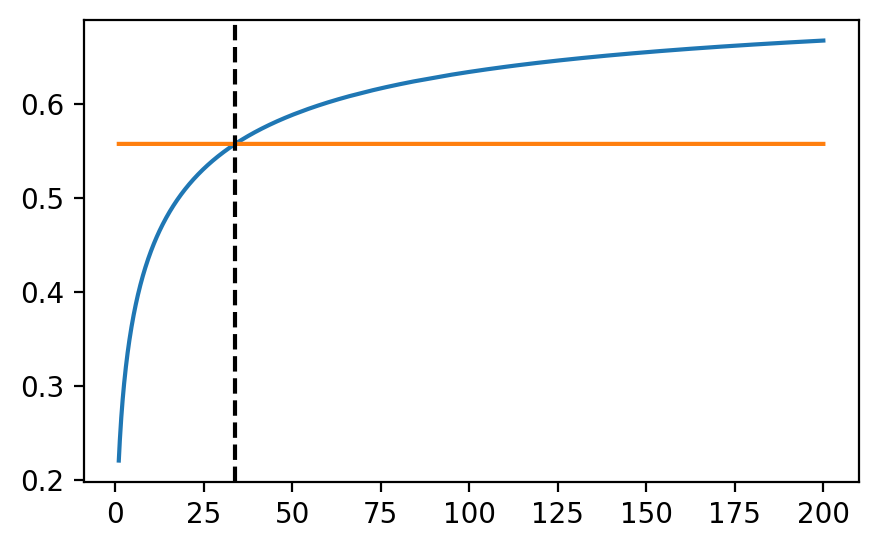

In [12]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='C']['Ratio'].values[0]

#fit equilibrium fraction community C
c_prod_T = np.arange(1,200.1,0.1)
community_C0 = community(ndim=3, lPro=fit_pars['lPro'], 
                         lTrp=fit_pars['lTrp'], 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT'], 
                         mu_dP=growth_rates['dP_trpOP'], 
                         c_prod_T=c_prod_T)

c_prod_T_fit, idx0 = fit_1D(c_prod_T, eq_data, community_C0.eq)
fit_pars['c_prod_T'] = c_prod_T_fit 

#report fit parameters
print(f"c_prod_T_P = {c_prod_T_fit:.2f}, eqFrac = {community_C0.eq[idx0]:.2f}, relmu = {community_C0.rel_growth_wt[idx0]:.2f}")
report_data(df_mean, 'C')
plt.show()

----

## Characterize proB74 using community E

We fit increase in pro leakage caused by proB74 mutation by fitting model to equilibrium fraction of community E (dT-proB74 + dP)

c_prod_P = 6.60, eqFrac = 0.16, relmu = 0.11
Experiments: CE: f(dT) = 0.16, rel. growth = 0.68, sectors dP = 227.43um, sectors dT = 117.14um, sector ratio = 2.03


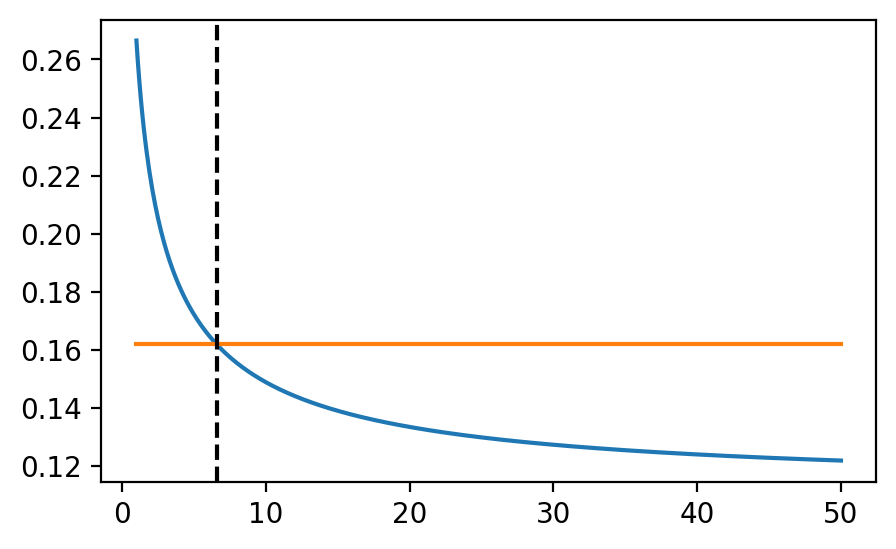

In [13]:
#get measured value
eq_data = df_mean.loc[df_mean['Condition']=='E']['Ratio'].values[0]

#ft equilibrium fraction community E
c_prod_P = np.arange(1,50.1,0.1)
community_E0 = community(ndim=3, 
                         mu_WT=growth_rates['WT'], 
                         mu_dT=growth_rates['dT_proOP'], 
                         mu_dP=growth_rates['dP'], 
                         c_prod_P=c_prod_P,
                         lPro=fit_pars['lPro'], 
                         lTrp=fit_pars['lTrp'])

c_prod_P_fit, idx0 = fit_1D(c_prod_P, eq_data, community_E0.eq)
fit_pars['c_prod_P'] = c_prod_P_fit 

#report fit parameters
print(f"c_prod_P = {c_prod_P_fit:.2f}, eqFrac = {community_E0.eq[idx0]:.2f}, relmu = {community_E0.rel_growth_wt[idx0]:.2f}")
report_data(df_mean, 'E')
plt.show()

---

## Report fitting results

In [14]:
#store pre-processed data
df_mean.to_csv('Processed-datafiles/community_data_mean.csv', index=False)
#store parameter values
with open('Processed-datafiles/fit_parameters.txt', 'w') as file:
    file.write(str(fit_pars))
    file.close()
#print parameters
print(fit_pars)

{'lPro': np.float64(6.424033659394191e-07), 'lTrp': np.float64(4.7062248498412815e-08), 'c_prod_T': np.float64(33.90000000000003), 'c_prod_P': np.float64(6.600000000000005)}
